In [1]:
import math
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Saves price and accessibility attribute to PT LoS table
## Needs PT LoS table and links

In [2]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
los = stepmodel.read_json(model_path + 'de_pt_los')

In [4]:
sm.pt_los = los.pt_los

## Prices

In [5]:
# Cost function
def monetary_cost(length, rf, vc, ac, al, ec, el, sf):
    """ calculate monetary cost of travelling one O-D realtion within the LoS table
    :param length: length of main leg in meter
    :param df: regression factor for length (to be calibrated beforehand)
    :param vc: distance-specific transport cost
    :param ac: access cost
    :param al: access link length (m)
    :param ec: egress cost
    :param el: egress link length (m)
    :param sf: sharing factor (e.g. occupancy factor of a car)
    :return: monetary cost"""
    return (math.pow(length, rf) * vc + ac * al + ec * el) / sf

In [6]:
# Load list of distance-related cost
c = pd.read_csv(input_path + 'level_of_service_DB_2020_preisliste_fahrplanjahr_2020.csv')
c.head(3)

,km,single_trip_second_class,single_trip_first_class,return_trip_second_class,return_trip_first_class
0,37.0,10.1,16.2,20.2,32.4
1,38.0,10.3,16.5,20.6,33.0
2,39.0,10.4,16.6,20.8,33.2


<AxesSubplot:xlabel='km'>

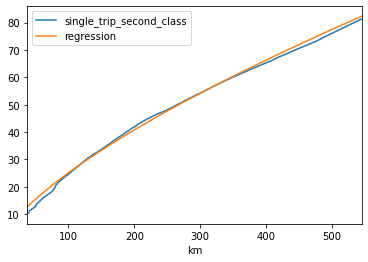

In [7]:
# Use second class single trip prices
# Choose a fit for a distance range up to 1000 km (longer trips are rare)
rf_rail = 0.7
c['regression'] = c['km'].apply(lambda km: math.pow(km, rf_rail))
c.loc[0:500, ['km', 'single_trip_second_class', 'regression']].set_index('km').plot()

In [8]:
# Bus trips are free but get a fare assigned in LOS table
sm.links['price'] = 0

In [9]:
# Generate length for PT links as the crow flies
if 'length' not in sm.links.columns:
    sm.links['length'] = sm.links['geometry'].apply(
        lambda l: geodesic(l.coords[0], l.coords[-1]).m)

In [10]:
# Long distance rail links
# Will be revised later
sm.links.loc[sm.links['route_type']=='rail_long', 'price'] = \
    sm.links['length'].apply(lambda l: monetary_cost(l/1000, rf_rail, 1,
                                                     0, 0, 0, 0, 1))

In [11]:
# Short distance rail links
sm.links.loc[sm.links['route_type']=='rail_short', 'price'] = \
    sm.links['length'].apply(lambda l: monetary_cost(l/1000, rf_rail, 1,
                                                     0, 0, 0, 0, 1))

In [12]:
# Coach links
# Average cost in Germany: https://de.statista.com/statistik/daten/studie/380601/umfrage/kilometerpreise-fernbuslinien-in-deutschland/
sm.links.loc[sm.links['route_type']=='coach', 'price'] = \
    sm.links['length'].apply(lambda l: monetary_cost(l/1000, 1, 0.107,
                                                     0, 0, 0, 0, 1))

Average economy price: 94.22058823529412 EUR
Average business price: 277.8235294117647 EUR


<AxesSubplot:xlabel='time'>

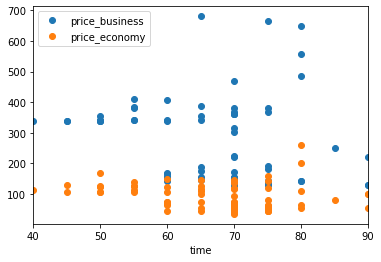

In [13]:
# Air links: Match them with prices from Sept. 2020
# Load connection list
air = pd.read_excel(input_path + 'public_transport_air_connections_germany.xlsx', engine='xlrd')
air = air.loc[air['direct']==True]
air['a'] = air['origin'].str[:3]
air['b'] = air['destination'].str[:3]
print('Average economy price: {} EUR'.format(air['price_economy'].mean()))
print('Average business price: {} EUR'.format(air['price_business'].mean()))
air[['price_business', 'price_economy', 'time']].set_index('time').plot(linestyle=' ', marker='o')

In [14]:
# Correct air time if neccessary
if sm.links.loc[sm.links['route_type']=='air', 'time'].mean() < 5*60:
    # Convert time to seconds
    sm.links.loc[sm.links['route_type']=='air', 'time'] = \
        sm.links.loc[sm.links['route_type']=='air', 'time'] * 60

In [15]:
# Air trips
# Take the economy price because its share is higher
# than 90% within Germany
air['trip'] = air['a'] + '-' + air['b']
price_dict = air.set_index('trip', drop=True)['price_economy'].to_dict()
sm.links.loc[sm.links['route_type']=='air', 'price'] = \
    sm.links.loc[sm.links['route_type']=='air', 'trip_id'].map(price_dict)
print(len(sm.links.loc[(sm.links['route_type']=='air') & (sm.links['price'].isna())]))
sm.links.loc[sm.links['route_type']=='air'].head(3)

0


,a,b,route_type,geometry,link_sequence,route_id,time,trip_id,length,headway,price
index,,,,,,,,,,,
air_0,HAM,DUS,air,"LINESTRING (9.98823 53.63040, 6.76678 51.28950)",1,air_0,3600,HAM-DUS,439767,5400,65.0
air_1,HAM,CGN,air,"LINESTRING (9.98823 53.63040, 7.14274 50.86590)",1,air_1,3600,HAM-CGN,437766,5400,72.0
air_2,HAM,FRA,air,"LINESTRING (9.98823 53.63040, 8.57056 50.03333)",1,air_2,4200,HAM-FRA,425174,5400,145.0


In [16]:
# Sum up prices in LoS table based on link fares
price_dict = sm.links['price'].to_dict()
sm.pt_los['price'] = sm.pt_los['link_path'].apply(
    lambda l: sum([price_dict[link] for link in l]))

In [17]:
# Add a fare for local transport services
# Average value from ADAC: https://www.adac.de/reise-freizeit/ratgeber/tests/oepnv-preise-vergleich/
sm.pt_los.loc[sm.pt_los['route_types'].apply(
    lambda t: 'bus' in t), 'price'] = \
    sm.pt_los['price'] + 2.74

In [18]:
sm.pt_los.groupby('route_type').agg(
    {'time': 'mean', 'price': 'mean', 'length': 'mean', 'ntransfers': 'mean'})

,time,price,length,ntransfers
route_type,,,,
air,16558.170795,148.161411,727123.572684,2.697005
bus,6522.873737,2.740000,356889.750398,6.534587
coach,16448.554187,28.245195,299287.671730,1.517720
rail_long,15960.010627,149.748902,524888.683809,2.776904
rail_short,12415.782910,145.557242,457746.453195,5.255289
walk,970.338521,0.000000,0.000000,0.000000


## Accessibility

In [19]:
def accessibility(dist_origin, dist_destination, weight=20):
    '''calculate an accessibility metric based on distances
    :param dist_origin: distance to the next mean of transport from origin in km
    :param dist_destination: distance from the used mean of transport to destination in km
    :param weight: (optional) weight of distance values
    :return: accessibility factor on a range from 0 to 1'''
    return max(0, 1 - dist_origin/weight - dist_destination/weight)

In [20]:
# Take average weighted distances to the next PT stop
# They were computed in prep16 from census data
clusters = pd.read_csv('../input/spatial_census_refined_FID.csv')
dist_col = 'weighted_dist'
mean_dist_col = 'mean_weighted_dist'
cent_col = 'cluster_center'
#pop_col = 'population'
# Convert to km
clusters[mean_dist_col] = clusters[mean_dist_col] / 1000

In [21]:
type_dict = {'rail_short_distance': 'rail_short', 'rail_long_distance': 'rail_long'}
clusters['route_type'].replace(type_dict, inplace=True)
mean_w_dist_dict = clusters.groupby(
    ['FID', 'route_type']).agg(
    {mean_dist_col: 'mean'}).to_dict()[mean_dist_col]

In [22]:
# The accessibility is a metric from the mean weighted distance in km
sm.pt_los['accessibility'] = 1

In [23]:
# Divide into PT and all walk
walk = sm.pt_los.loc[sm.pt_los['link_path'].apply(lambda l: len(l)==0)]
pt = sm.pt_los.loc[sm.pt_los['link_path'].apply(lambda l: len(l)>0)]

In [24]:
link_type = sm.links['route_type'].to_dict()
def get_accessibility(o, d, l_path, weight=20):
    try:
        return accessibility(mean_w_dist_dict[o, link_type[l_path[0]]],
                             mean_w_dist_dict[d, link_type[l_path[-1]]],
                             weight)
    except KeyError:
        # No such type in this region
        return 0

In [25]:
pt['accessibility'] = [get_accessibility(*a) for a in tuple(
    zip(pt['origin'], pt['destination'], pt['link_path'])#, [30 for _ in range(len(pt))])
)]

In [26]:
pt.groupby('route_type').agg(
    {'accessibility': 'mean', 'origin': 'count'})

,accessibility,origin
route_type,,
air,0.035453,48608
bus,0.067864,225054
coach,0.063267,92494
rail_long,0.053604,260090
rail_short,0.085994,439252


route_type
air           [[AxesSubplot(0.125,0.125;0.775x0.755)]]
bus           [[AxesSubplot(0.125,0.125;0.775x0.755)]]
coach         [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_long     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_short    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

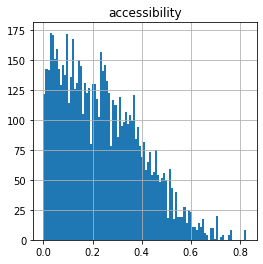

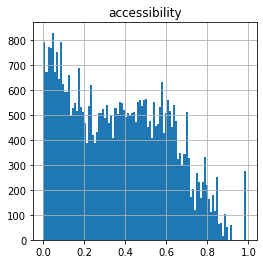

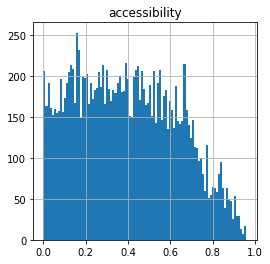

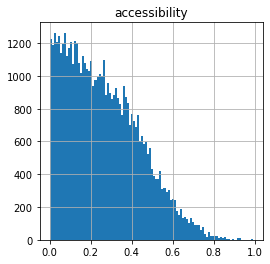

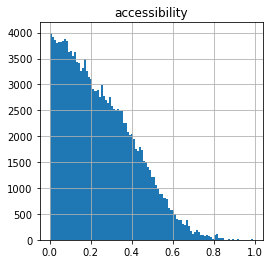

In [27]:
# The accessibility does not depend on the
# route_type columns of pt_los, but on the link path
pt.loc[pt['accessibility']>0].groupby('route_type').hist(
    column='accessibility', bins=100, figsize=(4,4), log=False)

In [28]:
sm.pt_los = pt.append(walk)

## Save

In [29]:
print(sm.pt_los.columns)
print(sm.pt_los.shape)
sm.pt_los.sample(3)

Index(['origin', 'destination', 'route_types', 'link_path', 'ntransfers',
       'access_time', 'footpath_time', 'in_vehicle_time', 'waiting_time',
       'time', 'price', 'length', 'route_type', 'accessibility'],
      dtype='object')
(1067297, 14)


,origin,destination,route_types,link_path,ntransfers,access_time,footpath_time,in_vehicle_time,waiting_time,time,price,length,route_type,accessibility
index,,,,,,,,,,,,,,
1176340,DEB3D,DEA5B,[rail_short],"[r_s_25176, r_s_25184, r_s_25186, r_s_25188, r...",5,2190,0,5220,5400,12810,148.653577,403400,rail_short,0.0
421483,DE259,DE123_2,[rail_long],"[r_l_5648, r_l_9298, r_l_4641, r_l_4642, r_l_4...",2,2682,399,8100,2700,13881,105.631032,405260,rail_long,0.0
1368660,DEF0B,DEA51,[rail_long],"[r_l_7010, r_l_7011, r_l_7012, r_l_7013, r_l_7...",1,1874,0,14820,1800,18494,169.307783,604608,rail_long,0.0


In [30]:
sm.to_json(model_path + 'de_pt_los',
           only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 35/35 [00:14<00:00,  2.40it/s]


In [31]:
# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['link_sequence', 'route_id', 'time', 'trip_id', 'length', 'headway', 'price']
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)

In [32]:
sm.to_json(model_path + 'de_pt_network_agg', only_attributes=[
    'zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 35/35 [00:30<00:00,  1.16it/s]


In [33]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + 'de_pt_network_agg/links_quetzaldata.json')